# Find best thresholds

This notebook estimates the best threshold to use for a model, based on inference on the training set. 
This threshold is then used for inference on the test set.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from tifffile import imread, imwrite
import numpy as np
from stardist import matching
import sys
sys.path.append("../")
from utils import *

In [3]:
DATA_PATH = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/RESULTS/SUPERVISED_PERF_FIG/TRAINING"
gt_path = DATA_PATH / "dataset_float32/labels/semantic"

models_pred_path = [(DATA_PATH / f"fold{i+1}").resolve() for i in range(3)] 

In [4]:
models = ["SegRes", "Swin"]
gt_images = {}
# load images in gt_path
for img_path in gt_path.glob("*.tif"):
    img = imread(img_path)
    gt_images[img_path.stem[:2]] = img

In [5]:
# for each fold and model, the goal is to compute what is the best threshold for the model, based on Dice between the GT and the prediction
dices_df = pd.DataFrame(columns=["Model", "Image", "Threshold", "Dice", "Fold"])
for model in models:
    print(f"Model: {model}")
    for model_pred_path in models_pred_path:
        print("Fold : ", model_pred_path.name)
        preds_path = model_pred_path / model
        for i, img_path in enumerate(preds_path.glob("*.tif")):
            img_name = img_path.stem
            print(f"Image: {img_name[:2]}")
            img = imread(img_path)
            gt = gt_images[img_name[:2]]
            for thresh in np.arange(0.1, 1, 0.05):
                pred = np.where(img > thresh, 1, 0)
                dice = dice_coeff(y_true=gt, y_pred=pred)
                dices_df.loc[len(dices_df.index)] = [model, img_name[:2], thresh, dice, model_pred_path.name]

Model: SegRes
Fold :  fold1
Image: c1
Image: c2
Image: c3
Image: c4
Image: c5
Fold :  fold2
Image: c1
Image: c2
Image: c3
Image: c4
Image: vi
Fold :  fold3
Image: c1
Image: c2
Image: c4
Image: c5
Image: vi
Model: Swin
Fold :  fold1
Image: c1
Image: c2
Image: c3
Image: c4
Image: c5
Fold :  fold2
Image: c1
Image: c2
Image: c3
Image: c4
Image: vi
Fold :  fold3
Image: c1
Image: c2
Image: c4
Image: c5
Image: vi


In [6]:
dices_df

,Model,Image,Threshold,Dice,Fold
0,SegRes,c1,0.10,0.237704,fold1
1,SegRes,c1,0.15,0.673025,fold1
2,SegRes,c1,0.20,0.770711,fold1
3,SegRes,c1,0.25,0.816153,fold1
4,SegRes,c1,0.30,0.834418,fold1
...,...,...,...,...,...
535,Swin,vi,0.75,0.477228,fold3
536,Swin,vi,0.80,0.343970,fold3
537,Swin,vi,0.85,0.210349,fold3
538,Swin,vi,0.90,0.096221,fold3


In [7]:
segres_df = dices_df[dices_df["Model"] == "SegRes"]
segres_df.groupby("Fold").apply(lambda x: x.loc[x["Dice"].idxmax()])

1616977455.py (2): DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,Model,Image,Threshold,Dice,Fold
Fold,,,,,
fold1,SegRes,c5,0.20,0.850224,fold1
fold2,SegRes,c2,0.30,0.850286,fold2
fold3,SegRes,c5,0.15,0.845207,fold3


In [8]:
# show Dices across folds for best threshold 
segres_df.groupby("Threshold").Dice.median().sort_values(ascending=False).head(5)

Threshold
0.30    0.830399
0.25    0.824799
0.20    0.809045
0.35    0.804280
0.40    0.758587
Name: Dice, dtype: float64

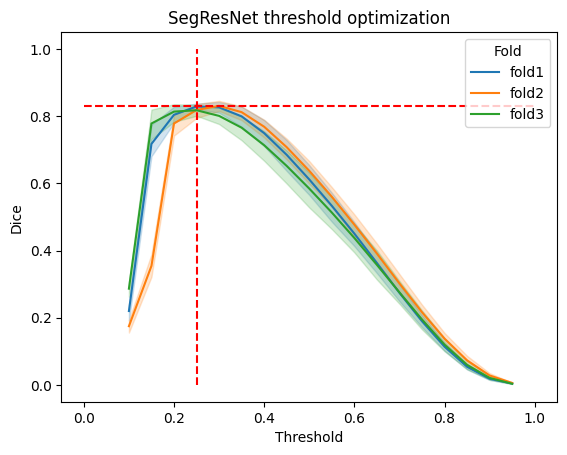

In [9]:
# plot for SegRes
sns.lineplot(data=segres_df, x="Threshold", y="Dice", hue="Fold")
plt.hlines(y=segres_df.groupby("Threshold").Dice.median().max(), xmin=0, xmax=1, color="red", linestyles="--")
plt.vlines(x=0.3, ymin=0, ymax=1, color="red", linestyles="--")
plt.title("SegResNet threshold optimization")
plt.show()

In [10]:
# repeat for Swin
swin_df = dices_df[dices_df["Model"] == "Swin"]
swin_df.groupby("Fold").apply(lambda x: x.loc[x["Dice"].idxmax()])

59275710.py (3): DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,Model,Image,Threshold,Dice,Fold
Fold,,,,,
fold1,Swin,c5,0.25,0.874404,fold1
fold2,Swin,c1,0.40,0.874802,fold2
fold3,Swin,c1,0.45,0.868225,fold3


In [11]:
swin_df.groupby("Threshold").Dice.median().sort_values(ascending=False).head(5)

Threshold
0.40    0.852899
0.35    0.848177
0.45    0.842413
0.50    0.814542
0.55    0.753670
Name: Dice, dtype: float64

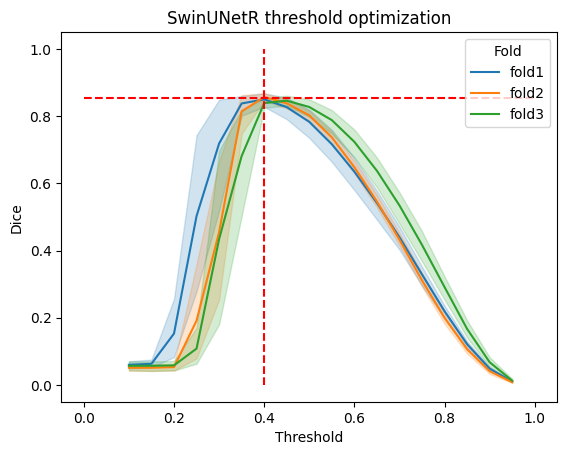

In [12]:
sns.lineplot(data=swin_df, x="Threshold", y="Dice", hue="Fold")
plt.hlines(y=swin_df.groupby("Threshold").Dice.median().max(), xmin=0, xmax=1, color="red", linestyles="--")
plt.vlines(x=0.4, ymin=0, ymax=1, color="red", linestyles="--")
plt.title("SwinUNetR threshold optimization")
plt.show()

In [13]:
image_folder = DATA_PATH / "../../SPLITS/Analysis"
c5 = imread(image_folder / "c5.tif")
c3 = imread(image_folder / "c3.tif")
visual = imread(image_folder / "visual.tif")

gt_dict = {
    "visual": visual,
    "c3": c3,
    "c5": c5,
}

In [14]:
def find_images(path, split):
    return list(path.glob(f"*{split}*.tif"))

In [15]:

visual_preds = {
    "SegResNet": {
        "2080": find_images(image_folder / "c1_5/segres", "2080")[0],
        "6040": find_images(image_folder / "c1_5/segres", "6040")[0],
        "8020": find_images(image_folder / "c1_5/segres", "8020")[0],
    },
    "SwinUNetR": {
        "2080": find_images(image_folder / "c1_5/swin", "2080")[0],
        "6040": find_images(image_folder / "c1_5/swin", "6040")[0],
        "8020": find_images(image_folder / "c1_5/swin", "8020")[0],
    },
}
c3_preds = {
    "SegResNet": {
        "2080": find_images(image_folder / "c1245_v/segres", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/segres", "6040")[0],
        "8020": find_images(image_folder / "c1245_v/segres", "8020")[0],
    },
    "SwinUNetR": {
        "2080": find_images(image_folder / "c1245_v/swin", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/swin", "6040")[0],
        "8020": find_images(image_folder / "c1245_v/swin", "8020")[0],
    },
}
c5_preds = {
    "SegResNet": {
        "2080": find_images(image_folder / "c1-4_v/segres", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/segres", "6040")[0],
        "8020": find_images(image_folder / "c1-4_v/segres", "8020")[0],
    },
    "SwinUNetR": {
        "2080": find_images(image_folder / "c1-4_v/swin", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/swin", "6040")[0],
        "8020": find_images(image_folder / "c1-4_v/swin", "8020")[0],
    },
}


In [16]:
df = pd.DataFrame()
splits = [visual_preds, c3_preds, c5_preds]
for i, gt_name in enumerate(gt_dict):
    preds = splits[i]
    for model_name in preds:
        for split in preds[model_name]:
            gt = gt_dict[gt_name]
            df = pd.concat([df, pd.DataFrame({
                "model": model_name,
                "split": split[:2] + "/" + split[2:],
                "gt": gt_name,
                "path": [preds[model_name][split]],
            })])
df.reset_index(inplace=True, drop=True)
df

,model,split,gt,path
0,SegResNet,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
1,SegResNet,60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
2,SegResNet,80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
3,SwinUNetR,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
4,SwinUNetR,60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
5,SwinUNetR,80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
6,SegResNet,20/80,c3,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
7,SegResNet,60/40,c3,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
8,SegResNet,80/20,c3,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
9,SwinUNetR,20/80,c3,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...


In [17]:
# for each entry in the dataframe, compute the Dice between the GT and the prediction based on a threshold
dices_df = pd.DataFrame(columns=["Model", "Split", "Threshold", "Dice", "GT"])
thresholds = np.arange(0.1, 1, 0.05)
for i, row in df.iterrows():
    img = imread(row["path"])
    gt = gt_dict[row["gt"]]
    for thresh in thresholds:
        pred = np.where(img > thresh, 1, 0)
        gt = np.where(gt > 0, 1, 0)
        dice = dice_coeff(y_true=gt, y_pred=pred)
        dices_df.loc[len(dices_df.index)] = [row["model"], row["split"], thresh, dice, row["gt"]]

In [18]:
dices_df

,Model,Split,Threshold,Dice,GT
0,SegResNet,20/80,0.10,0.061105,visual
1,SegResNet,20/80,0.15,0.148637,visual
2,SegResNet,20/80,0.20,0.312530,visual
3,SegResNet,20/80,0.25,0.416132,visual
4,SegResNet,20/80,0.30,0.517674,visual
...,...,...,...,...,...
319,SwinUNetR,80/20,0.75,0.223646,c5
320,SwinUNetR,80/20,0.80,0.142326,c5
321,SwinUNetR,80/20,0.85,0.073483,c5
322,SwinUNetR,80/20,0.90,0.026901,c5


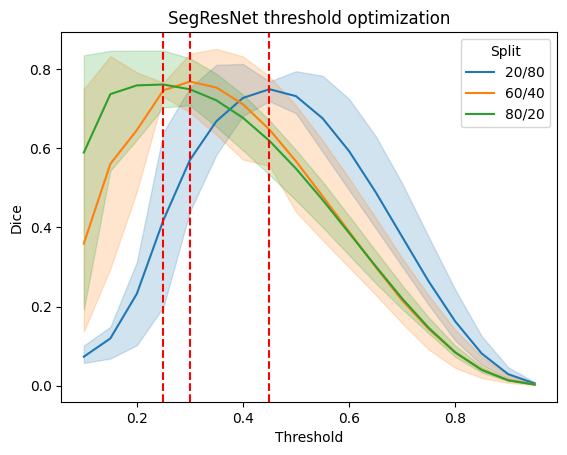

In [19]:
sns.lineplot(data=dices_df[dices_df["Model"] == "SegResNet"], x="Threshold", y="Dice", hue="Split")
plt.title("SegResNet threshold optimization")
plt.axvline(x=0.25, color="red", linestyle="--")
plt.axvline(x=0.3, color="red", linestyle="--")
plt.axvline(x=0.45, color="red", linestyle="--")

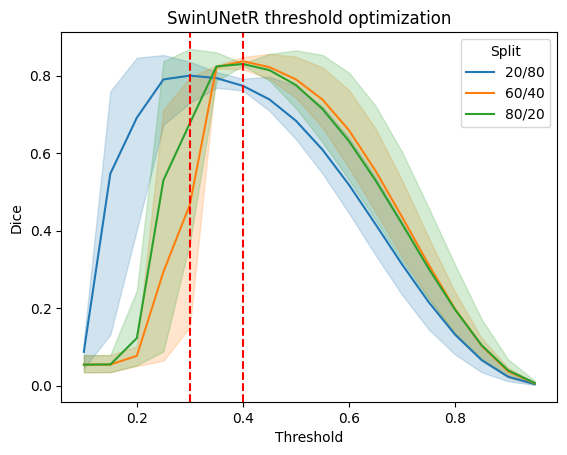

In [20]:
sns.lineplot(data=dices_df[dices_df["Model"] == "SwinUNetR"], x="Threshold", y="Dice", hue="Split")
plt.title("SwinUNetR threshold optimization")
plt.axvline(x=0.3, color="red", linestyle="--")
plt.axvline(x=0.4, color="red", linestyle="--")